In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Relax, Inc. Takehome Data Challenge

Defining an *adopted user* as a user who has logged into the product on three separate days in at least one seven-day period, identify which factors predict future user adoption.

## ingest

### user table

In [2]:
users = pd.read_csv('data/raw/takehome_users.csv', encoding='latin-1')

In [3]:
users.shape

(12000, 10)

* **name**: the user's name

* **object_id**: the user's id

* **email**: email address

* **creation_source**: how their account was created. This takes on one
of 5 values:
    * **PERSONAL_PROJECTS**: invited to join another user's personal workspace
    * **GUEST_INVITE**: invited to an organization as a guest (limited permissions)
    * **ORG_INVITE**: invited to an organization (as a full member)
    * **SIGNUP**: signed up via the website
    * **SIGNUP_GOOGLE_AUTH**: signed up using Google Authentication (using a Google email account for their login id)
    
* **creation_time**: when they created their account
* **last_session_creation_time**: unix timestamp of last login
* **opted_in_to_mailing_list**: whether they have opted into receiving marketing emails
* **enabled_for_marketing_drip**: whether they are on the regular marketing email drip
* **org_id**: the organization (group of users) they belong to
* **invited_by_user_id**: which user invited them to join (if applicable)

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


### usage table

This table contains a row for each day a user logged into the product.

In [6]:
usage = pd.read_csv("data/raw/takehome_user_engagement.csv")

In [7]:
usage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [8]:
usage.shape

(207917, 3)

In [9]:
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


### wrangling datatype

In [10]:
# categorical features
cat_cols = ['name', 'email', 'creation_source', 'org_id']
for col in cat_cols:
    users[col] = users[col].astype("category")

In [11]:
# datetime features
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s') # unix timestamp
usage['time_stamp'] = pd.to_datetime(usage['time_stamp'])

In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null category
email                         12000 non-null category
creation_source               12000 non-null category
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null category
invited_by_user_id            6417 non-null float64
dtypes: category(4), datetime64[ns](2), float64(1), int64(3)
memory usage: 1.5 MB


### handling null values

#### users

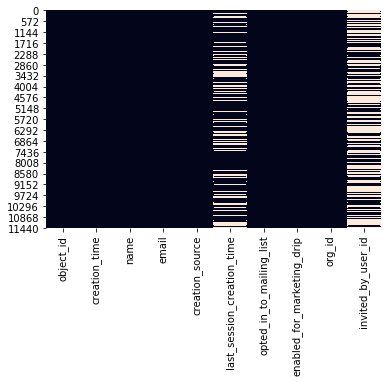

In [13]:
sns.heatmap(users.isnull(), cbar=False)

Are these values missing because the creation is the only login, or because they haven't been filled in correctly?

In [14]:
null_users = users[users['last_session_creation_time'].isnull()]['object_id'].unique()

In [15]:
usage[usage['user_id'].isin(null_users)]

,time_stamp,user_id,visited


...because the account creation is the only login.

impute last session creation time with account creation time if empty

In [16]:
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(users['creation_time'])

Since user id starts at 1, a missing value will have a user id of 0 (no user invited the user to join).

In [17]:
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)

In [18]:
users['invited_by_user_id'] = users['invited_by_user_id'].astype('category')

In [19]:
df = pd.merge(usage, users, left_on='user_id', right_on='object_id')
df = df.drop(columns=['object_id'])
df.head(30)

,time_stamp,user_id,visited,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,2013-11-29 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
3,2013-12-09 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
4,2013-12-25 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
5,2013-12-31 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
6,2014-01-08 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
7,2014-02-03 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
8,2014-02-08 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
9,2014-02-09 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0


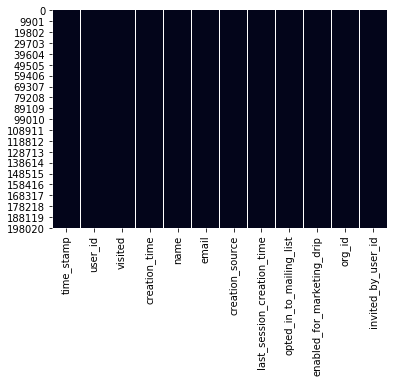

In [20]:
sns.heatmap(df.isnull(), cbar=False)

In [21]:
df.shape[0] - df.dropna().shape[0]

0

### feature architecture

We're interested in the number of unique login dates for each user, so we'll pull out the date as its own time period.

In [22]:
df['date'] = df['time_stamp'].dt.date

In [23]:
df.head()

,time_stamp,user_id,visited,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,date
0,2014-04-22 03:53:30,1,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,2014-04-22
1,2013-11-15 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-11-15
2,2013-11-29 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-11-29
3,2013-12-09 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-09
4,2013-12-25 03:45:04,2,1,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,2013-12-25


## exploration

In [24]:
df = df.set_index('time_stamp')

In [25]:
df = df.sort_index()

In [26]:
grouped = df.groupby('user_id')['date'].resample('7d').nunique()

In [27]:
grouped_nonzero = grouped[grouped > 0]

The number of unique login dates for each seven-day period:

In [28]:
grouped_nonzero.head(10)

user_id  time_stamp
1        2014-04-22    1
2        2013-11-15    1
         2013-11-29    1
         2013-12-06    1
         2013-12-20    1
         2013-12-27    1
         2014-01-03    1
         2014-01-31    1
         2014-02-07    3
         2014-02-14    1
Name: date, dtype: int64

In [29]:
at_least_three = grouped_nonzero[grouped_nonzero >=3]

In [30]:
adopted_users = at_least_three.index.get_level_values(level=0).unique()

In [31]:
adopted_users = list(adopted_users)

## add labels to user table

In [32]:
users['adopted_user'] = np.where(users['object_id'].isin(adopted_users), 1, 0)

In [33]:
users['adopted_user'].dtype

dtype('int64')

In [34]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


#### sanity check

It should be the case that no adopted users have the same value in the timestamp and last session fields.

In [35]:
users[users['last_session_creation_time'] == users['creation_time']]['adopted_user'].unique()

array([0])

Looking good.

## exploration of the obvious

A small portion of users are adopted users.

In [36]:
users[users['adopted_user'] == 1].shape[0]/users.shape[0]

0.12266666666666666

 It should the case that mailing list membership and market drip opt-in yield a higher chance of adopted usership. Is this true?

In [37]:
adopted_users = users[users['adopted_user'] == 1]

In [38]:
adopted_users['opted_in_to_mailing_list'].value_counts()

0    1087
1     385
Name: opted_in_to_mailing_list, dtype: int64

In [39]:
users[users['adopted_user'] == 0]['opted_in_to_mailing_list'].value_counts()

0    7919
1    2609
Name: opted_in_to_mailing_list, dtype: int64

In [40]:
adopted_users['enabled_for_marketing_drip'].value_counts()

0    1245
1     227
Name: enabled_for_marketing_drip, dtype: int64

In [41]:
users[users['adopted_user'] == 0]['enabled_for_marketing_drip'].value_counts()

0    8963
1    1565
Name: enabled_for_marketing_drip, dtype: int64

Interesting. Neither list membership nor marketing opt-in correlate with adopted-usership in the expected way.

## feature architecture

Perhaps the day of the week someone created their account correlates with adopted usership?

In [42]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null category
email                         12000 non-null category
creation_source               12000 non-null category
last_session_creation_time    12000 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null category
invited_by_user_id            12000 non-null category
adopted_user                  12000 non-null int64
dtypes: category(5), datetime64[ns](2), int64(4)
memory usage: 1.6 MB


In [43]:
users['weekday_of_creation'] = users['creation_time'].dt.weekday_name.astype('category')

Can someone invite themself to join?

In [44]:
users[users['invited_by_user_id'] == users['object_id']].head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,weekday_of_creation
22,23,2012-08-17 08:30:27,Souza Alice,AliceAraujoSouza@gustr.com,ORG_INVITE,2012-08-18 08:30:27,1,0,6,23.0,0,Friday
49,50,2012-06-03 11:02:08,Oliveira Gabrielly,GabriellyAlmeidaOliveira@gmail.com,GUEST_INVITE,2012-10-23 11:02:08,0,0,61,50.0,0,Sunday
120,121,2013-01-03 23:57:39,Toft Dennis,DennisMToft@cuvox.de,GUEST_INVITE,2013-01-03 23:57:39,1,0,402,121.0,0,Thursday
177,178,2012-06-08 14:44:58,Brauer Daniela,DanielaBrauer@gmail.com,ORG_INVITE,2012-06-08 14:44:58,0,0,415,178.0,0,Friday
192,193,2012-10-30 04:15:49,Rocha Erick,ErickPintoRocha@jourrapide.com,ORG_INVITE,2012-10-30 04:15:49,1,0,122,193.0,0,Tuesday


In [45]:
users['invited_self'] = np.where(users['invited_by_user_id'] == users['object_id'], 1, 0)

In [46]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,weekday_of_creation,invited_self
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,Tuesday,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,Friday,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0,Tuesday,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0,Tuesday,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0,Thursday,0


## random forests 

To find out which features matter most in predicting adoptd user status, we'll use many decision trees and have a look at the random forest's relative feature importance.

### consider unique labels for categorical data

In [68]:
# features
X=users[['creation_source',
         'opted_in_to_mailing_list', 
         'enabled_for_marketing_drip', 
         'invited_by_user_id',
         'org_id',
        ]]
# Labels
y=users['adopted_user']

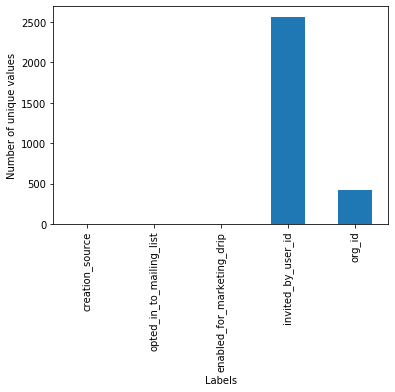

In [69]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = X.apply(pd.Series.nunique)

# Plot number of unique values for each label
num_unique_labels.plot(kind='bar')

# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

# Display the plot
plt.show()

### binarizing categorical data

In [70]:
X = pd.get_dummies(X, prefix_sep='_')

In [71]:
X.shape

(12000, 2989)

In [72]:
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,invited_by_user_id_0.0,invited_by_user_id_3.0,invited_by_user_id_7.0,...,org_id_407,org_id_408,org_id_409,org_id_410,org_id_411,org_id_412,org_id_413,org_id_414,org_id_415,org_id_416
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
rf = RandomForestClassifier(n_estimators=10, class_weight='balanced')

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [113]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [114]:
y_pred = rf.predict(X_test)

In [115]:
# Compute the accuracy: accuracy
accuracy = float(np.sum(predictions==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))
print(classification_report(y_test, y_pred))

accuracy: 0.836389
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      3117
           1       0.18      0.11      0.14       483

    accuracy                           0.81      3600
   macro avg       0.53      0.52      0.52      3600
weighted avg       0.78      0.81      0.79      3600



The model predicts adopted usership with an accuracy of 84\%; however, accuracy isn't the best metric here, because we have relatively few positive labels for adopted usership.

In [116]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index')

In [118]:
importances.sort_values(by=0, ascending=False).rename(columns={0:'importance'}).head(10)

,importance
opted_in_to_mailing_list,0.036811
enabled_for_marketing_drip,0.024532
creation_source_PERSONAL_PROJECTS,0.014871
creation_source_SIGNUP,0.007711
creation_source_GUEST_INVITE,0.006530
creation_source_ORG_INVITE,0.006115
creation_source_SIGNUP_GOOGLE_AUTH,0.005797
org_id_1,0.005691
org_id_0,0.005489
invited_by_user_id_0.0,0.005103


The random forest classifier's feature importance ranking shows which features the forest's decision trees found most informative with respect to prediction. Marketing status (mailing list and marketing drip) most significantly predicted adopted usership. After this, presence of personal initiative (person project or signup motivation) and then social incentive (guest or organization invite) play a role. Beyond this, the classifier found diminishing significance for membership in various organizations.

In [89]:
power_orgs = [35, 306, 62, 370]

In [93]:
users[users['org_id'].isin(power_orgs)]['adopted_user'].value_counts()

0    97
1    29
Name: adopted_user, dtype: int64

Users within these organizations are a bit more likely to be adopted users (20\% over the general 12\%).

In [97]:
users[users['creation_source'] == 'GUEST_INVITE']['adopted_user'].value_counts()

0    1831
1     332
Name: adopted_user, dtype: int64

Self-invitation ranks high as a factor against user adoption:

In [99]:
users[users['invited_by_user_id'] == 0]['adopted_user'].value_counts()

0    4947
1     636
Name: adopted_user, dtype: int64